In [18]:
import numpy as np
import uproot as up
import pandas as pd
import matplotlib.pyplot as plot
import matplotlib.mlab as mlab
from scipy.stats import norm
import pylandau

#### Set any parameters here to select the root file and prepare the plots

In [19]:
# particle = "pi"
particle = "mu"
length = "1.5"
length_dict = {
    "2.5" : "2_5",
    "2" : "2",
    "1.5" : "1_5"
}
color_dict = {
    "pi" : "green",
    "mu" : "blue"
}

#### Nest, open the root file with uproot and save the times to a Numpy Array

In [20]:
# uproot_path = f"/cwork/rck32/eic/work_eic/root_files/time_res/one_segment_sensor_in_volume/{particle}_5GeV_10kevents_{length_dict[length]}m_1cm_3cm.edm4hep.root:events"
# uproot_path = f"/cwork/rck32/eic/work_eic/root_files/time_res/one_segment_test/{particle}_5GeV_100events_{length_dict[length]}m_1cm_3cm_28_layers.edm4hep.root:events"
# uproot_path = f"/cwork/rck32/eic/work_eic/root_files/time_res/one_segment_sensor_in_volume/June_6/{particle}_5GeV_10kevents_{length_dict[length]}m_1cm_3cm.edm4hep.root:events"
uproot_path = f"/hpc/group/vossenlab/rck32/eic/work_eic/root_files/time_res_one_segment_sensor/May_5/run_1_mum_10GeV_theta_90_5kevents.edm4hep.root:events"

events = up.open(uproot_path)

times = events["HcalBarrelHits/HcalBarrelHits.time"].array(library='np')
cells = events["HcalBarrelHits/HcalBarrelHits.cellID"].array(library='np')
x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
y_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.y"].array(library='np')
z_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.z"].array(library='np')

#### Now we can loop over all events with the first index of the array and cut events with <2 optical photons
Goal: skip events with only 1 hit (noise) and search remaining events for first photon, ie photon with lowest time. Take that time 

In [5]:
def avg_time(num,event_times):
    ten_sorted_times = sorted(event_times)[:num]
    return sum(ten_sorted_times) / len(ten_sorted_times)

In [6]:
#Minimum number of pixels to be hit for us to accept event
threshold = 10
use_avg = False

In [21]:
class SiPMSignalProcessor:
    def __init__(self, 
                 sampling_rate=40e9,  # 40 GHz sampling rate
                 tau_rise=1.1e-9,       # 1 ns rise time
                 tau_fall=15e-9,      # 50 ns fall time
                 window=200e-9,       # 200 ns time window
                 cfd_delay=5e-9,      # 5 ns delay for CFD
                 cfd_fraction=0.3):   # 30% fraction for CFD
        
        self.sampling_rate = sampling_rate
        self.tau_rise = tau_rise
        self.tau_fall = tau_fall
        self.window = window
        self.cfd_delay = cfd_delay
        self.cfd_fraction = cfd_fraction
#         self.cfd_delay = self.tau_rise * (1 - self.cfd_fraction)
        
        # Time array for single pulse shape
        self.time = np.arange(0, self.window, 1/self.sampling_rate)
        
        # Generate single pulse shape
        self.pulse_shape = self._generate_pulse_shape()
    
    def _generate_pulse_shape(self):
        """Generate normalized pulse shape for a single photon"""
        shape = np.exp(-self.time/self.tau_fall) - np.exp(-self.time/self.tau_rise)
        return shape / np.max(shape)  # Normalize
    
    def generate_waveform(self, photon_times):
        """Generate waveform from list of photon arrival times"""
        # Initialize waveform array
        waveform = np.zeros_like(self.time)
        
        # Add pulse for each photon
        for t in photon_times:
            if 0 <= t < self.window:
                idx = int(t * self.sampling_rate)
                remaining_samples = len(self.time) - idx
                waveform[idx:] += self.pulse_shape[:remaining_samples]
        
        return self.time, waveform
    
    def integrate_charge(self, waveform, integration_start=0, integration_time=100e-9):
        """Integrate charge in specified time window"""
        start_idx = int(integration_start * self.sampling_rate)
        end_idx = int((integration_start + integration_time) * self.sampling_rate)
        
        # Integrate using trapezoidal rule
        charge = np.trapezoid(waveform[start_idx:end_idx], dx=1/self.sampling_rate)
        return charge
    def constant_threshold_timing(self,waveform,threshold):
        for i in range(len(self.time)):
            if(waveform[i] > threshold):
                return self.time[i]
        return None
        
    def apply_cfd(self,waveform):
        maximum = max(waveform)
        for i in range(len(self.time)):
            if(waveform[i] > maximum * self.cfd_fraction):
                return self.time[i]
        return None
    def apply_cfd_old(self, waveform, use_interpolation=True):
        """Apply Constant Fraction Discrimination to the waveform.

        Parameters:
        -----------
        waveform : numpy.ndarray
            Input waveform to process
        use_interpolation : bool, optional
            If True, use linear interpolation for sub-sample precision
            If False, return the sample index of zero crossing
            Default is True

        Returns:
        --------
        tuple (numpy.ndarray, float)
            CFD processed waveform and the zero-crossing time in seconds.
            If use_interpolation is False, zero-crossing time will be aligned
            to sample boundaries.
        """
        # Calculate delay in samples
        delay_samples = int(self.cfd_delay * self.sampling_rate)

        # Create delayed and attenuated versions of the waveform
        delayed_waveform = np.pad(waveform, (delay_samples, 0))[:-delay_samples]
        attenuated_waveform = -self.cfd_fraction * waveform

        # Calculate CFD waveform
        cfd_waveform = delayed_waveform + attenuated_waveform

        # Find all zero crossings
        zero_crossings = np.where(np.diff(np.signbit(cfd_waveform)))[0]

        if len(zero_crossings) < 2:  # Need at least two crossings for valid CFD
            return cfd_waveform, None

        # Find the rising edge of the original pulse
        pulse_start = np.where(waveform > np.max(waveform) * 0.1)[0]  # cfd fraction threshold
        if len(pulse_start) == 0:
            return cfd_waveform, None
        pulse_start = pulse_start[0]

        # Find the first zero crossing that occurs after the pulse starts
        valid_crossings = zero_crossings[zero_crossings > pulse_start]
        if len(valid_crossings) == 0:
            return cfd_waveform, None

        crossing_idx = valid_crossings[0]

        if not use_interpolation:
            # Simply return the sample index converted to time
            crossing_time = crossing_idx / self.sampling_rate
        else:
            # Use linear interpolation for sub-sample precision
            y1 = cfd_waveform[crossing_idx]
            y2 = cfd_waveform[crossing_idx + 1]

            # Calculate fractional position of zero crossing
            fraction = -y1 / (y2 - y1)

            # Calculate precise crossing time
            crossing_time = (crossing_idx + fraction) / self.sampling_rate

        return cfd_waveform, crossing_time


    def get_pulse_timing(self, waveform, threshold=3):
        """Get pulse timing using CFD method with additional validation.
        
        Parameters:
        -----------
        waveform : numpy.ndarray
            Input waveform to analyze
        threshold : float
            Minimum amplitude threshold for valid pulses (relative to max amplitude)
            
        Returns:
        --------
        float or None
            Timestamp of the pulse in seconds, or None if no valid pulse found
        """
        # Check if pulse amplitude exceeds threshold
        max_amplitude = np.max(waveform)
        if max_amplitude < threshold:
            return None
            
        # Apply CFD
        crossing_time = self.apply_cfd(waveform)
        
        return crossing_time

In [23]:
def theta_func(px,py,pz):
    return np.arccos(pz / np.sqrt(px ** 2 + py ** 2 + pz ** 2)) * 180 / np.pi
def phi_func(px,py,pz):
    return np.arctan2(py,px) * 180 / np.pi
def Efunc(px,py,pz,m):
    return np.sqrt(px**2 + py**2 + pz**2 + m**2)
def r_func(x,y,z):
    return np.sqrt(x**2 + y**2 + z**2)
def z_func(z_vertex, theta):
    return z_vertex + 6 * np.tan(np.pi / 2 - theta * np.pi / 180)

class PVect:
    def __init__(self):
        self.px = 0
        self.py = 0
        self.pz = 0
        self.theta = 0
        self.phi = 0
        self.E = 0
        self.M = 0
        self.P = 0
    def setVector(self,px,py,pz,m):
        self.px = px
        self.py = py
        self.pz = pz
        self.M = m
        self.E = Efunc(px,py,pz,m)
        self.P = r_func(self.px,self.py,self.pz)
        self.theta = theta_func(px,py,pz)
        self.phi = phi_func(px,py,pz)

class TimingResolution:
    def __init__(self,pixel_threshold = 2,useCFD = False):
        self.processor = SiPMSignalProcessor()
        self.pixel_threshold = pixel_threshold
        self.useCFD = useCFD
    def time_func(self,p,m,dx):
        """
        Calculate the hit time of a particle in the scintillator
        
        Calculates the velocity of the particle from the momentum
        and calculates how long the photon travels to the center of the scintillator.
        
        ...
        
        Parameters
        ----------
        p : double
            TODO: should this just be x momentum??
            Momentum of particle in GeV/c
        m : double
            Mass of particle in GeV/c
        dx : double
            Distance between particle gun position and scintillator
        
        Returns
        -------
        dx / v_mmpns : double
            Time between gun shoot and particle hit in scintillator.
        """
        c = 299792458 # 2.998 * 10 ^ 8 m/s
        c_n = 1 #c = 1 in natural units
        p_div_m = p / m
        vc = p_div_m * np.sqrt(1 / (1 + ((p_div_m) ** 2) * (1 / (c_n ** 2)))) # in terms of c
        v = vc * c #now in m/s
        v_mm = v * 1000 # in mm/s
        v_mmpns = v_mm / (10 ** (9)) # in mm/ns
        return dx / v_mmpns
    def apply_time_func(self, momentum_vector, m, vertex_vector):
        # Compute derived quantities
        primary = PVect()
        primary.setVector(momentum_vector[0], momentum_vector[1], momentum_vector[2], m)
        theta = primary.theta
        P = primary.P
        mu_incident_time = self.time_func(primary.px, primary.M, 1770.3 - vertex_vector[0])
        hit_z = z_func(vertex_vector[1], theta)
        return mu_incident_time, hit_z
    def process(self, root_file_path):
        events = up.open(root_file_path)
        times = events["HcalBarrelHits/HcalBarrelHits.time"].array(library='np')
        cells = events["HcalBarrelHits/HcalBarrelHits.cellID"].array(library='np')
        x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
        y_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.y"].array(library='np')
        z_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.z"].array(library='np')
        x_vertex_branch = events["MCParticles/MCParticles.vertex.x"].array(library='np')
        y_vertex_branch = events["MCParticles/MCParticles.vertex.y"].array(library='np')
        z_vertex_branch = events["MCParticles/MCParticles.vertex.z"].array(library='np')
        x_momentum_branch = events["MCParticles/MCParticles.momentum.x"].array(library='np')
        y_momentum_branch = events["MCParticles/MCParticles.momentum.y"].array(library='np')
        z_momentum_branch = events["MCParticles/MCParticles.momentum.z"].array(library='np')
        mass_branch = events["MCParticles/MCParticles.mass"].array(library='np')
        self.all_times = []
        self.accepted_times = []
        self.avg_accepted_times = []

        self.duplicates = 0
        self.total = 0
        self.total_cells = set()

        self.skipped = 0
        self.num_list = []
        #First loop over events
        for event_num in range(len(cells)):
            event_times = np.array(times[event_num])
            # Primary particle hit time
            momentum_vector = (x_momentum_branch[event_num][0],y_momentum_branch[event_num][0],z_momentum_branch[event_num][0])
            mass = mass_branch[event_num][0]
            vertex_vector = (x_vertex_branch[event_num][0],y_vertex_branch[event_num][0],z_vertex_branch[event_num][0])
            scint_hit_time, scint_hit_z = self.apply_time_func(momentum_vector, mass, vertex_vector)
            event_times -= scint_hit_time
            curr_set = set()
            curr_total = 0
            for photon_num in range(len(cells[event_num])):
                curr_set.add(cells[event_num][photon_num])
                self.total += 1
                curr_total += 1
            self.num_list.append(len(curr_set))
            #check if enough pixels are hit
            if(len(curr_set) < self.pixel_threshold): 
                self.skipped += 1
                continue
            self.accepted_times.append(min(times[event_num]))
            self.all_times.append(times[event_num])
            self.avg_accepted_times.append(self.avg_time(self.pixel_threshold,times[event_num]))
            self.duplicates += curr_total - len(curr_set)
            
        print(f"total: {self.total} | duplicates: {self.duplicates} | ratio: {self.duplicates / self.total} | num unique cells hit: {len(self.total_cells)} | skipped: {self.skipped}")

    def apply_SiPM(self):
        self.SiPM_timing = []
        for event_idx in range(len(self.all_times)):
            photon_time_list = np.array(self.all_times[event_idx]) * 10**(-9) # same conversion as in momentum_prediction_util.py newer_prepare_nn_input
#             print(photon_time_list)
            time_arr, waveform = self.processor.generate_waveform(photon_time_list)
            if(self.useCFD):
                timing = self.processor.get_pulse_timing(waveform, threshold=self.pixel_threshold) * 10 ** 9
            else:
                timing = self.processor.constant_threshold_timing(waveform,threshold = self.pixel_threshold)* 10 ** 9
            self.SiPM_timing.append(timing)
        return self.SiPM_timing
    def get_timing(self):
        return self.accepted_times
    def get_mean_std(self, values):
        return norm.fit(values)
    def avg_time(self,num,event_times):
        ten_sorted_times = sorted(event_times)[:num]
        return sum(ten_sorted_times) / len(ten_sorted_times)

In [25]:
root_file_path = f"/hpc/group/vossenlab/rck32/eic/work_eic/root_files/time_res_one_segment_sensor/May_5/run_1_mum_10GeV_theta_90_5kevents_with_rise_time.edm4hep.root:events"
TR = TimingResolution()
TR.process(root_file_path)
timing = TR.get_timing()
SiPM_timing = TR.apply_SiPM()

total: 203181 | duplicates: 6355 | ratio: 0.03127753087148897 | num unique cells hit: 0 | skipped: 0


Timing (mu, std) : (10.52 +/- 0.190) ns
SiPM timing (mu, std) : (11.26 +/- 0.241) ns


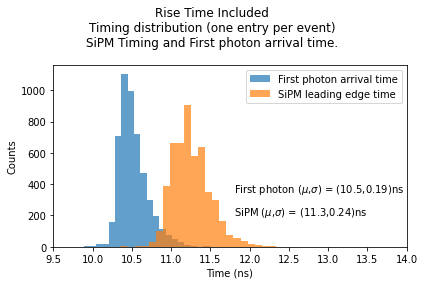

In [28]:
mu_timing, std_timing = TR.get_mean_std(timing)
mu_SiPM, std_SiPM = TR.get_mean_std(SiPM_timing)
print(f"Timing (mu, std) : ({mu_timing:0.2f} +/- {std_timing:0.3f}) ns")
print(f"SiPM timing (mu, std) : ({mu_SiPM:0.2f} +/- {std_SiPM:0.3f}) ns")

fig,axs = plot.subplots(1,1)
fig.suptitle("Rise Time Included\nTiming distribution (one entry per event)\nSiPM Timing and First photon arrival time.")
axs.hist(timing,bins = 50,alpha = 0.7, label = "First photon arrival time");
axs.hist(SiPM_timing,bins = 50,alpha = 0.7, label = "SiPM leading edge time");
axs.set(xlabel = "Time (ns)",ylabel = "Counts")
axs.legend()
axs.text(11.8, 350, fr"First photon ($\mu$,$\sigma$) = ({mu_timing:0.1f},{std_timing:0.2f})ns ")
axs.text(11.8, 200, fr"SiPM ($\mu$,$\sigma$) = ({mu_SiPM:0.1f},{std_SiPM:0.2f})ns ")
axs.set(xlim = (9.5,14))
fig.show()
fig.tight_layout()
fig.savefig("plots/Paper/SiPM_vs_first_photon_timing_resolution_with_rise_time.pdf")

Timing (mu, std) : (10.52 +/- 0.186) ns
SiPM timing (mu, std) : (11.26 +/- 0.232) ns


In [6]:
accepted_times = []
avg_accepted_times = []
rel_accepted_times = []

duplicates = 0
total = 0
total_cells = []

skipped = 0
num_list = []
#First loop over events
for event_num in range(len(cells)):
    
    #skip events with less than 2 photons
#     if(times[event_num].shape[0] < threshold): continue
    
    #Keep track of which cell IDs are hit
    curr_list = []
    for photon_num in range(len(cells[event_num])):
        if(cells[event_num][photon_num] in curr_list):
            duplicates += 1
        else:
            curr_list.append(cells[event_num][photon_num])
        if(cells[event_num][photon_num] not in total_cells):
            total_cells.append(cells[event_num][photon_num])
        total += 1
    num_list.append(len(curr_list))
    #check if 2 unique pixels are hit
    if(len(curr_list) < threshold): 
        skipped += 1
        continue
    accepted_times.append(min(times[event_num]))
    avg_accepted_times.append(avg_time(threshold,times[event_num]))
#     if(len(curr_list) == 15):
#         print(f"event #{event_num}")
print(f"total: {total} | duplicates: {duplicates} | ratio: {duplicates / total} | num unique cells hit: {len(total_cells)} | skipped: {skipped}")

total: 406858 | duplicates: 12761 | ratio: 0.03136475133830476 | num unique cells hit: 6471 | skipped: 0


#### We can plot the times in a histogram to visualize the result

#### Now we need to calculate the standard deviation and mean of this distribution

resolution (sigma): 0.182 | mean: 10.52 | FWHM: 0.427


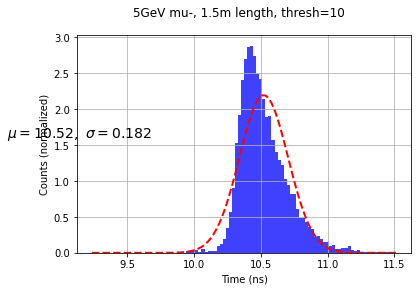

In [7]:
plot_times = avg_accepted_times if use_avg else accepted_times

fig, axs = plot.subplots(1, 1)

(mu, sigma) = norm.fit(plot_times)
n, bins, patches = plot.hist(plot_times, 100, facecolor=color_dict[particle], alpha=0.75, density=True)
fig.suptitle(f"5GeV {particle}-, {length}m length, thresh={threshold}")

y = norm.pdf( bins, mu, sigma)
l = axs.plot(bins, y, 'r--', linewidth=2)
axs.set_xlabel('Time (ns)')
axs.set_ylabel('Counts (normalized)')
axs.grid(True)
axs.text(8.6,1.6,r'$\mu=%4.2f,\ \sigma=%4.3f$'%(mu,sigma),fontsize=14)

fig.show()
extra_str = "_avg" if use_avg else ""
# fig.savefig(f"plots/June_6/{particle}_5GeV_{length_dict[length]}m_10k_events_{threshold}g_thresh{extra_str}.svg")
print("resolution (sigma): %4.3f | mean: %4.2f | FWHM: %4.3f" %(sigma,mu,(2.35 * sigma)))

In [38]:
counts = []
counts_cut = []
for i in range(times.shape[0]):
    count = len(times[i])
    counts.append(len(times[i]))
    if(count < 10 or count > 250):continue
    counts_cut.append(len(times[i]))
max_count = max(counts_cut)
min_count = min(counts_cut)
n_bins = max_count - min_count

Mean: 40.69 | Sigma: 12.150


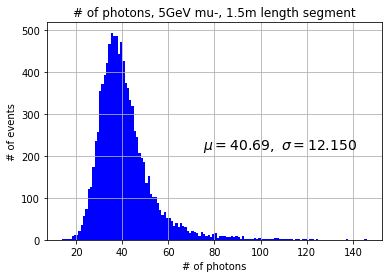

In [42]:
(mu, sigma) = norm.fit(counts_cut)
n, bins, patches = plot.hist(counts_cut, bins=n_bins, density = False,facecolor=color_dict[particle])
plot.title(f"# of photons, 5GeV {particle}-, {length}m length segment")
plot.xlabel("# of photons")
plot.ylabel("# of events")
plot.text(75,215,r'$\mu=%4.2f,\ \sigma=%4.3f$'%(mu,sigma),fontsize=14)
plot.grid(True)

plot.plot
plot.savefig(f"plots/June_6/counts_{particle}_5GeV_{length_dict[length]}m_10k_events_{threshold}g_thresh.svg")
print("Mean: %4.2f | Sigma: %4.3f"%(mu,sigma))

In [99]:
uproot_path = f"~/cworkdir/eic/work_eic/root_files/time_res/one_segment_test/mu_5GeV_1kevents_1_5m_1cm_3cm_test.edm4hep.root:events"
events = up.open(uproot_path)
cells = events["HcalBarrelHits/HcalBarrelHits.cellID"].array(library='np')
x_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.x"].array(library='np')
y_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.y"].array(library='np')
z_pos_branch = events["HcalBarrelHits/HcalBarrelHits.position.z"].array(library='np')

In [100]:
duplicates = 0
total = 0
total_cells = []
for i in range(len(cells)):
    curr_list = []
    for j in range(len(cells[i])):
        if(cells[i][j] in curr_list):
            duplicates += 1
        else:
            curr_list.append(cells[i][j])
        if(cells[i][j] not in total_cells):
            total_cells.append(cells[i][j])
        total += 1
print(f"total: {total} | duplicates: {duplicates} | ratio: {duplicates / total} | num unique cells hit: {len(total_cells)}")

total: 40495 | duplicates: 1251 | ratio: 0.030892702802815163 | num unique cells hit: 2547


In [101]:
np.sqrt(3) / ((50 * 0.0001))

346.41016151377545

In [102]:
x_pos = []
for i in range(len(x_pos_branch)):
    for j in range(len(x_pos_branch[i])):
        x_pos.append(x_pos_branch[i][j])
y_pos = []
for i in range(len(y_pos_branch)):
    for j in range(len(y_pos_branch[i])):
        y_pos.append(y_pos_branch[i][j])
z_pos = []
for i in range(len(z_pos_branch)):
    for j in range(len(z_pos_branch[i])):
        if(z_pos_branch[i][j] > 767.45):
            z_pos.append(z_pos_branch[i][j])

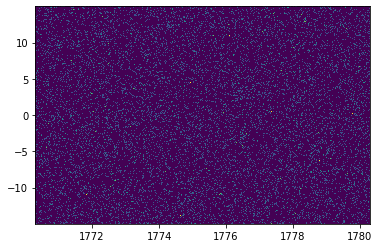

In [106]:
plot.hist2d(x_pos,y_pos,500)
plot.show()

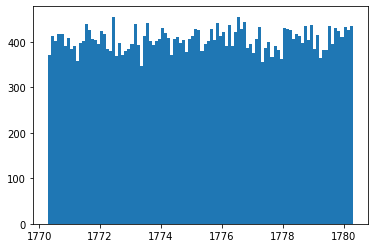

In [107]:
plot.hist(x_pos,100)
plot.show()

# OLD

In [180]:
# accepted_times = []

# #Note - array.shape[0] gives the first dimension of the array
# for event_num in range(times.shape[0]):
#     if(times[event_num].shape[0] < 2): continue
#     if(min(times[event_num]) > 12.5 or min(times[event_num]) < 9): continue
#     accepted_times.append(min(times[event_num]))

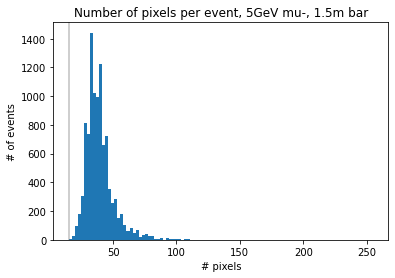

In [74]:
plot.hist(num_list,100)
plot.title("Number of pixels per event, 5GeV mu-, 1.5m bar")
plot.xlabel("# pixels")
plot.ylabel("# of events")
plot.axvline(x=15,color='gray',alpha=0.5)
plot.savefig("./plots/pixels.jpg")
plot.show()